[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


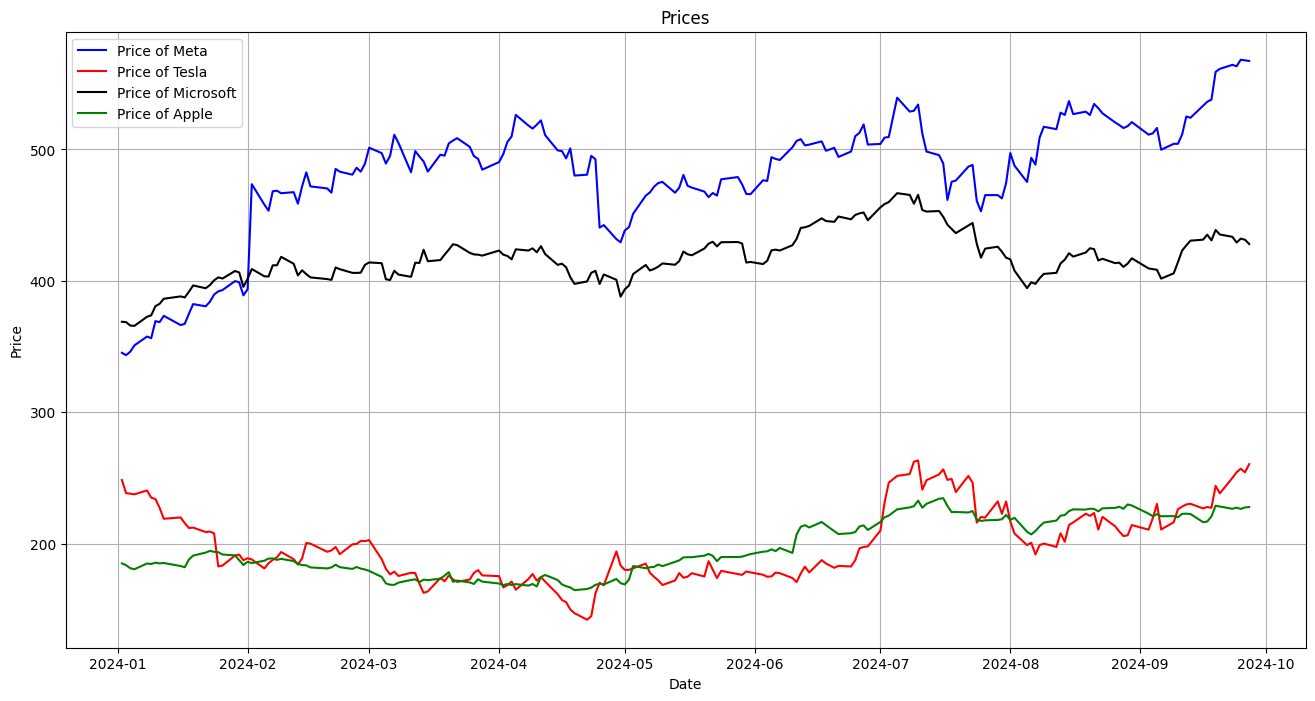

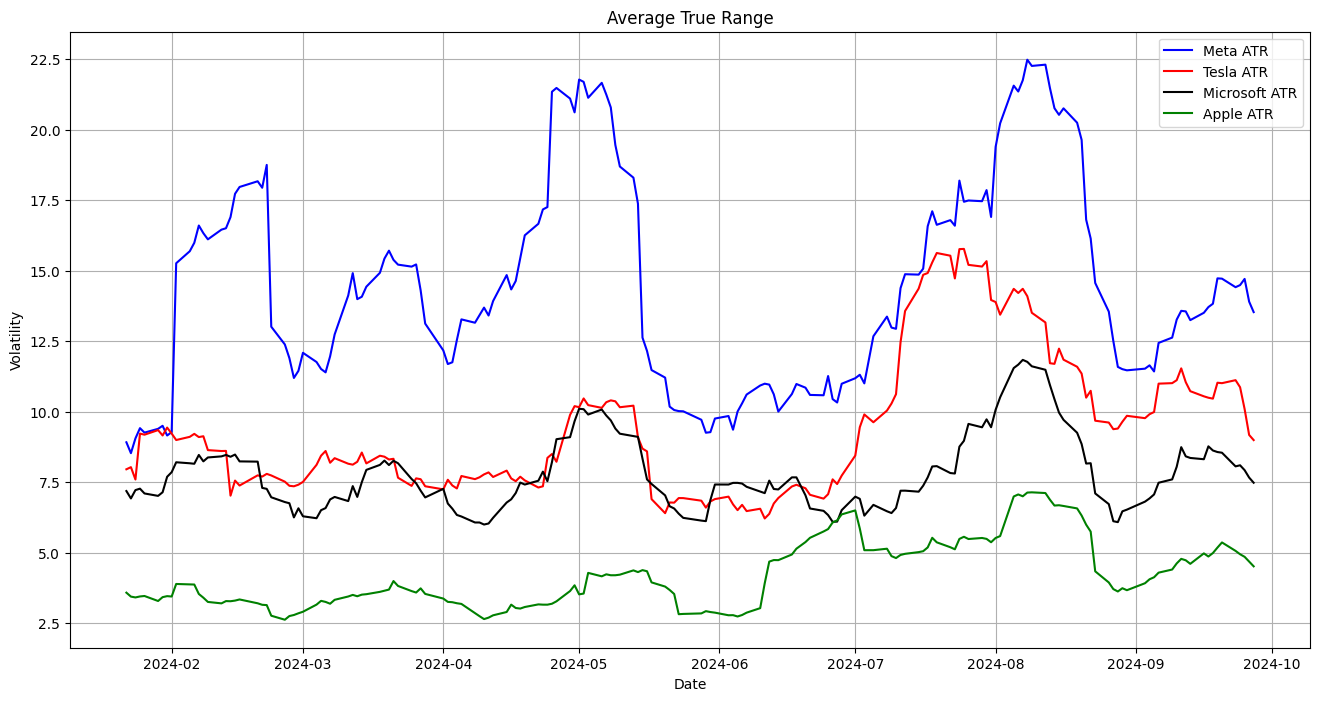

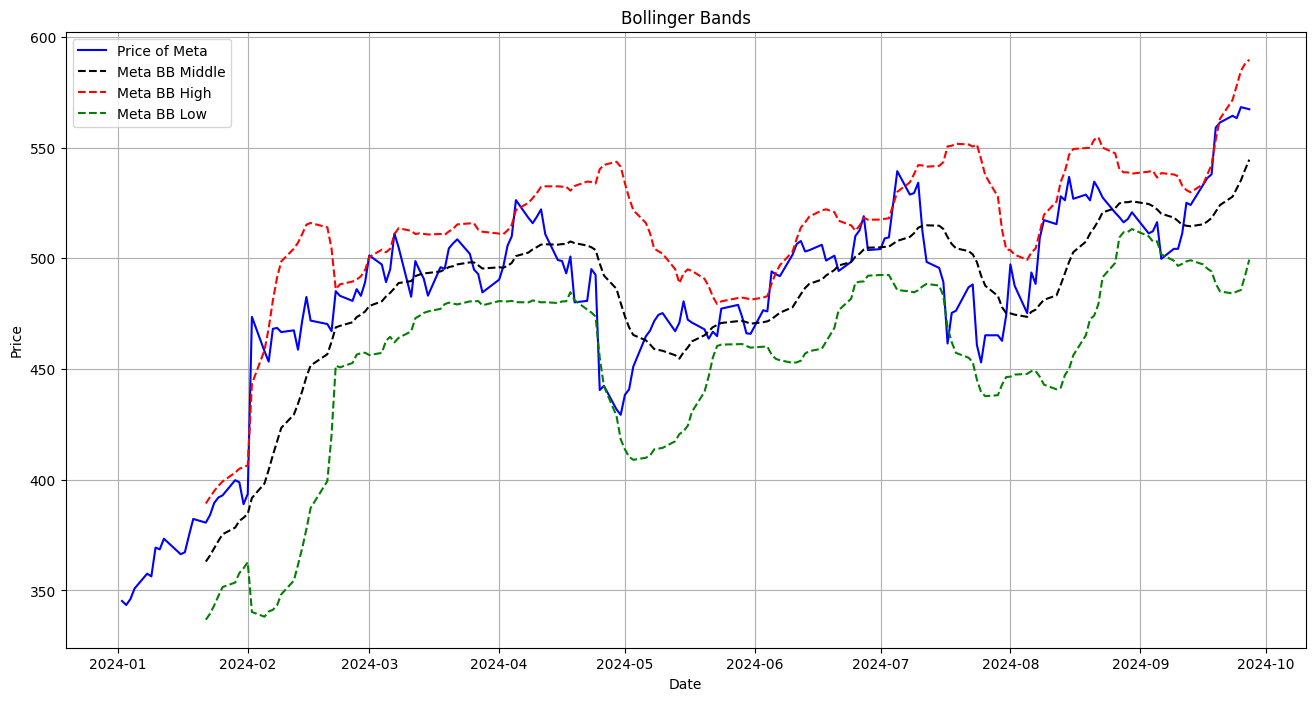

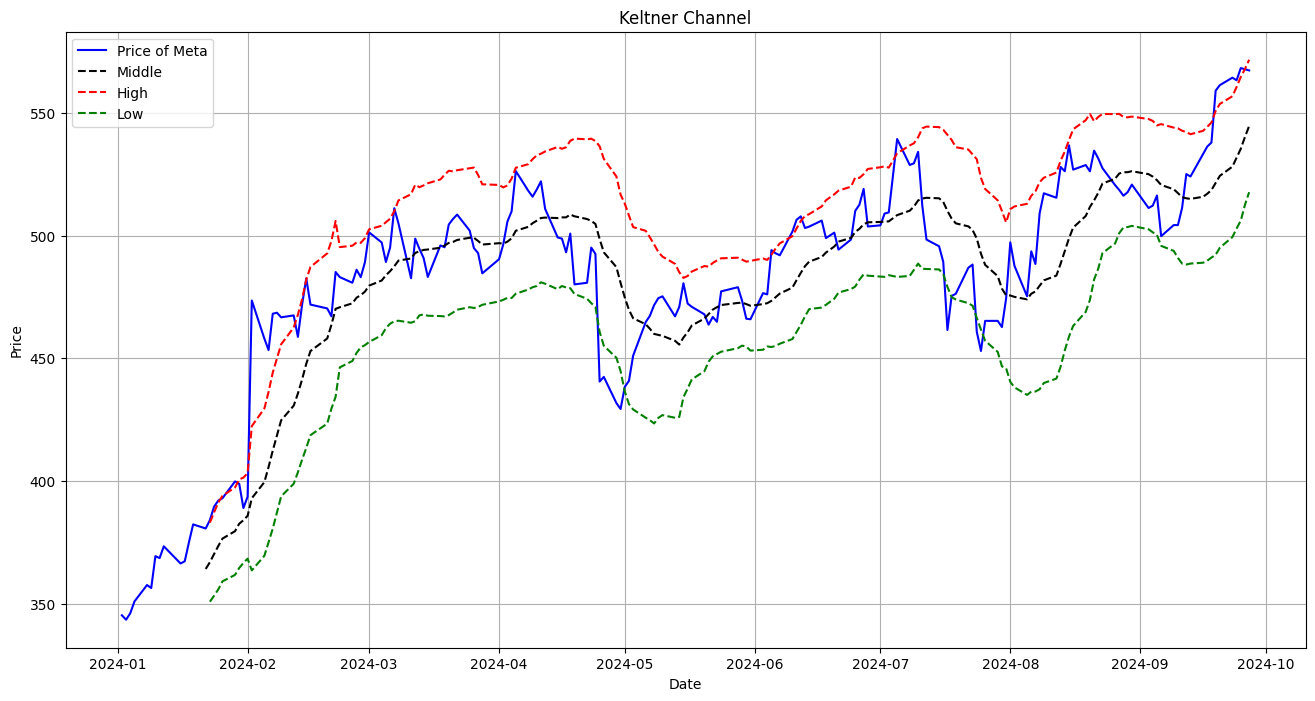

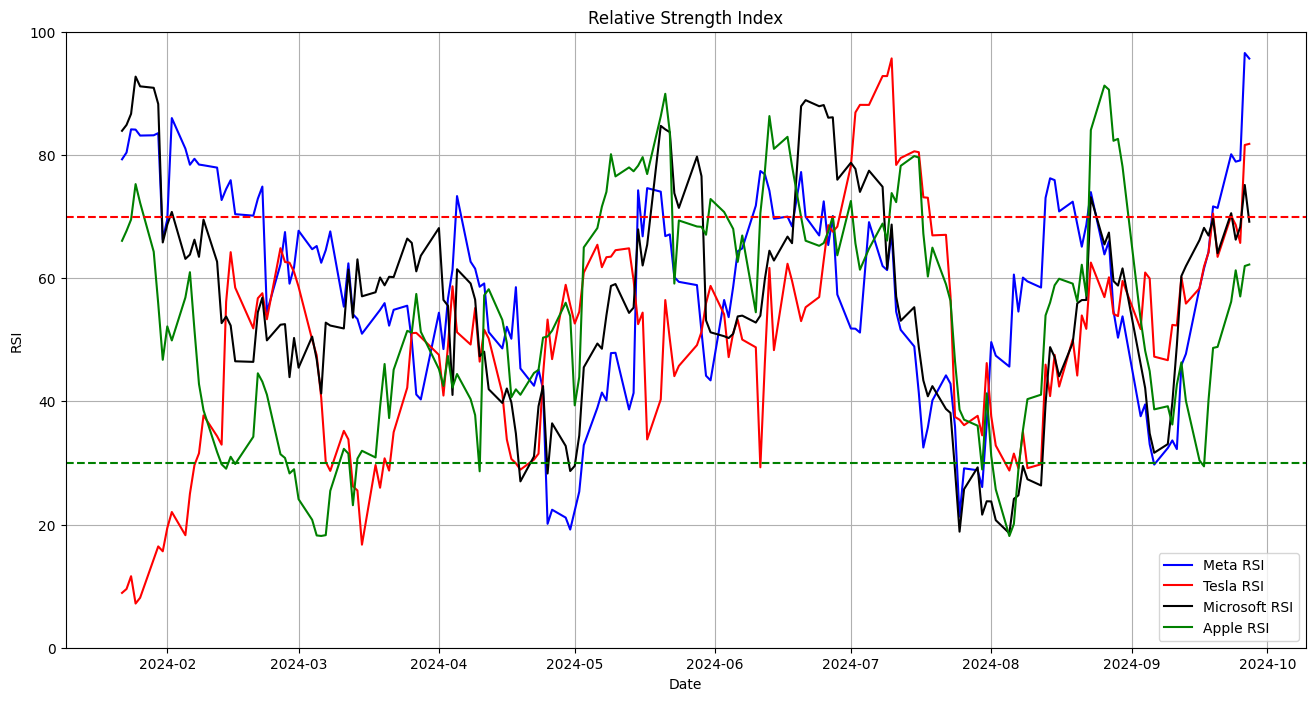

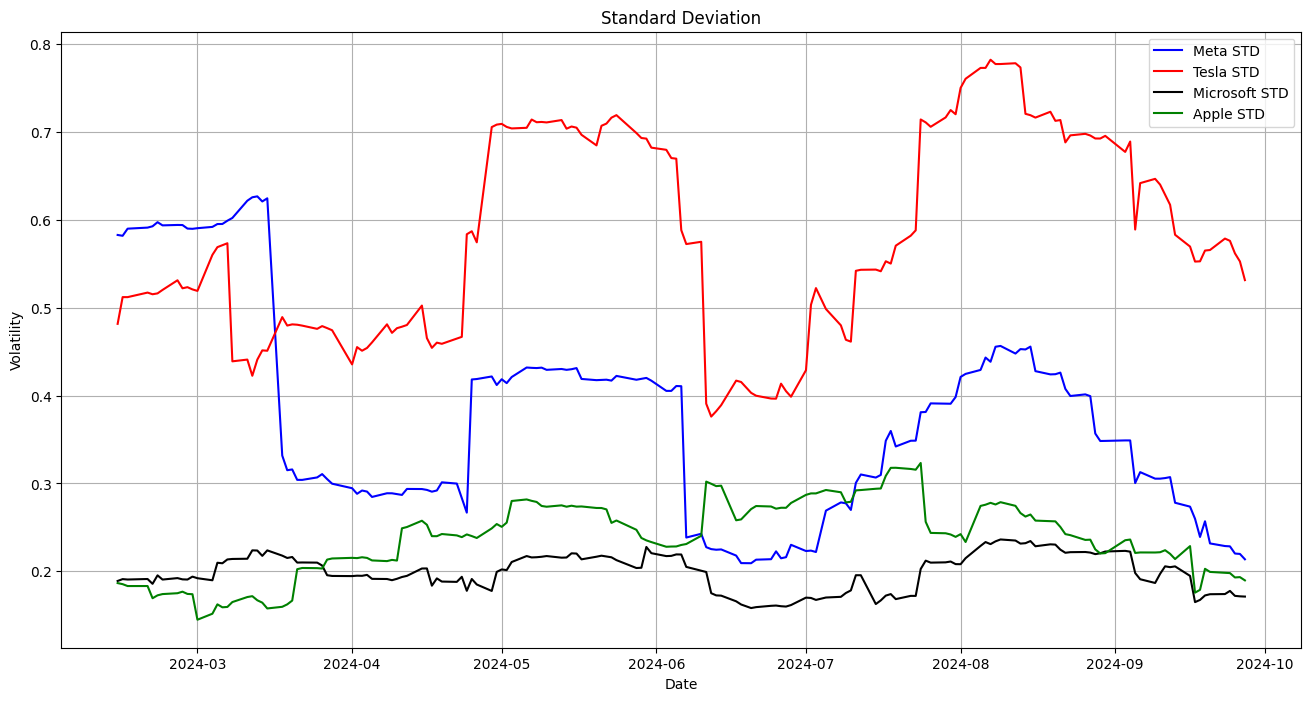

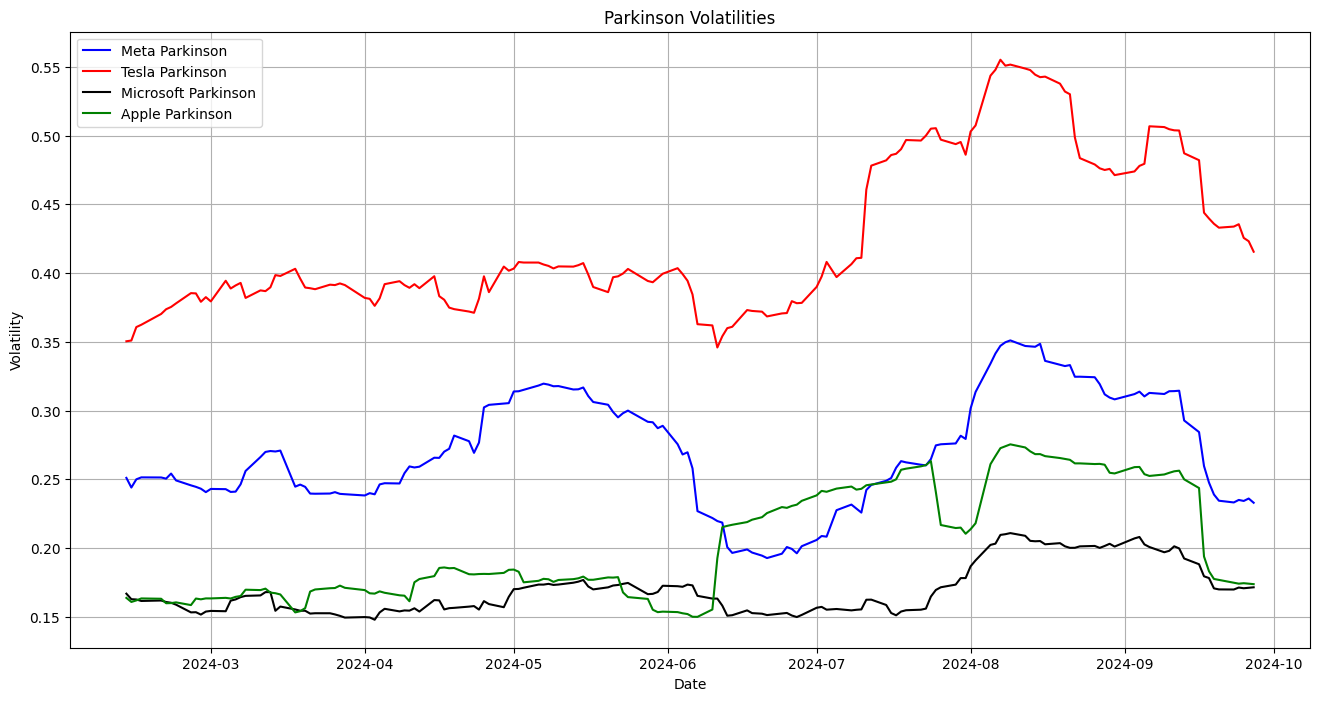

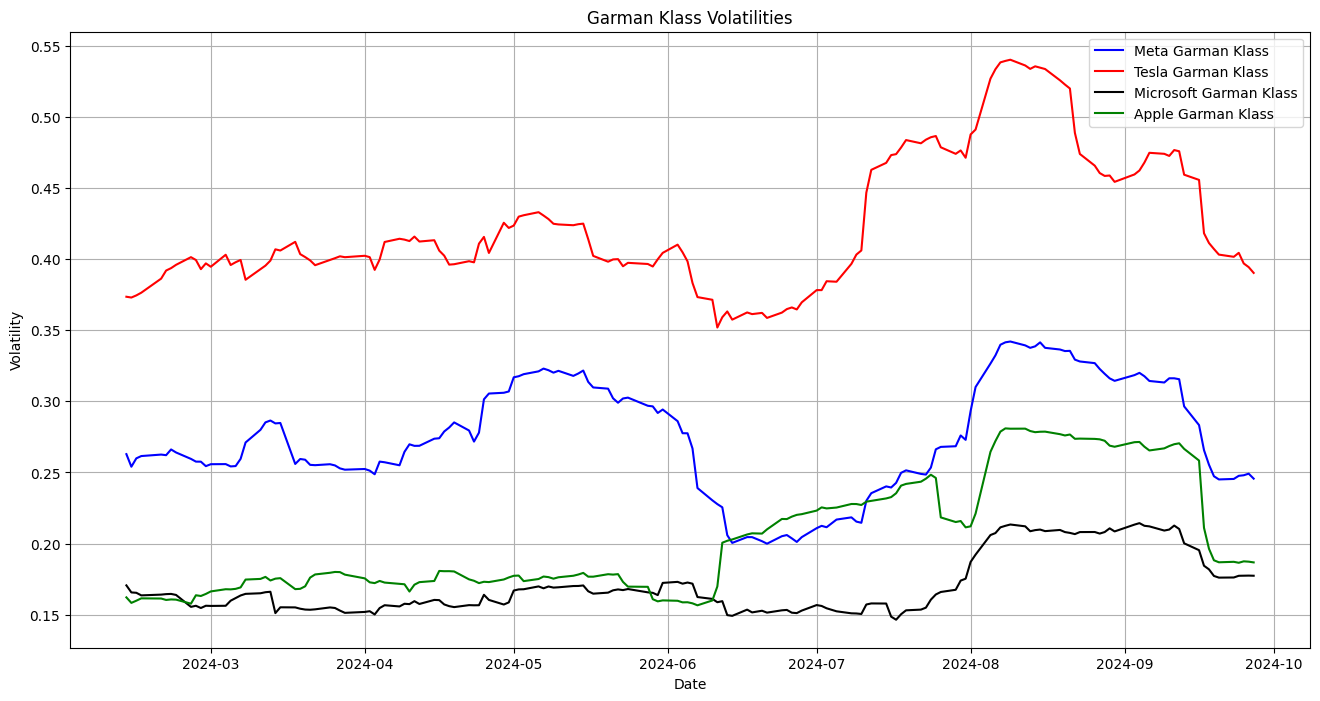

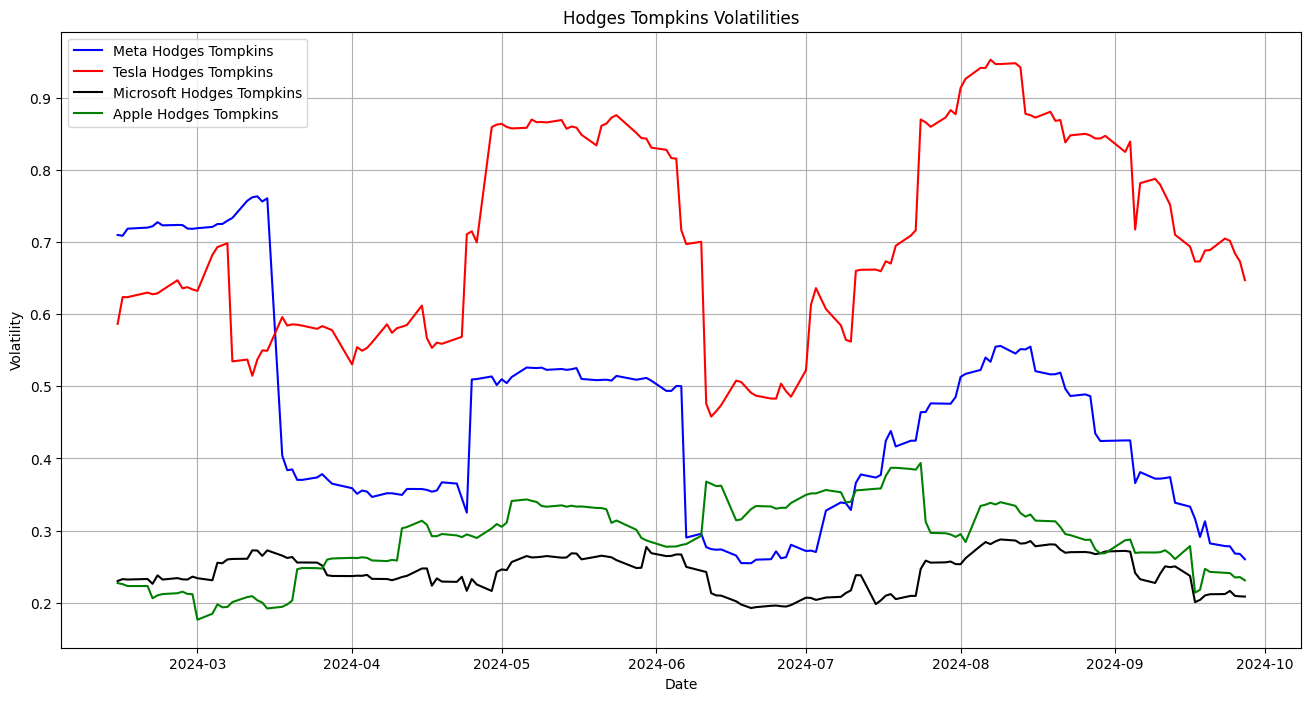

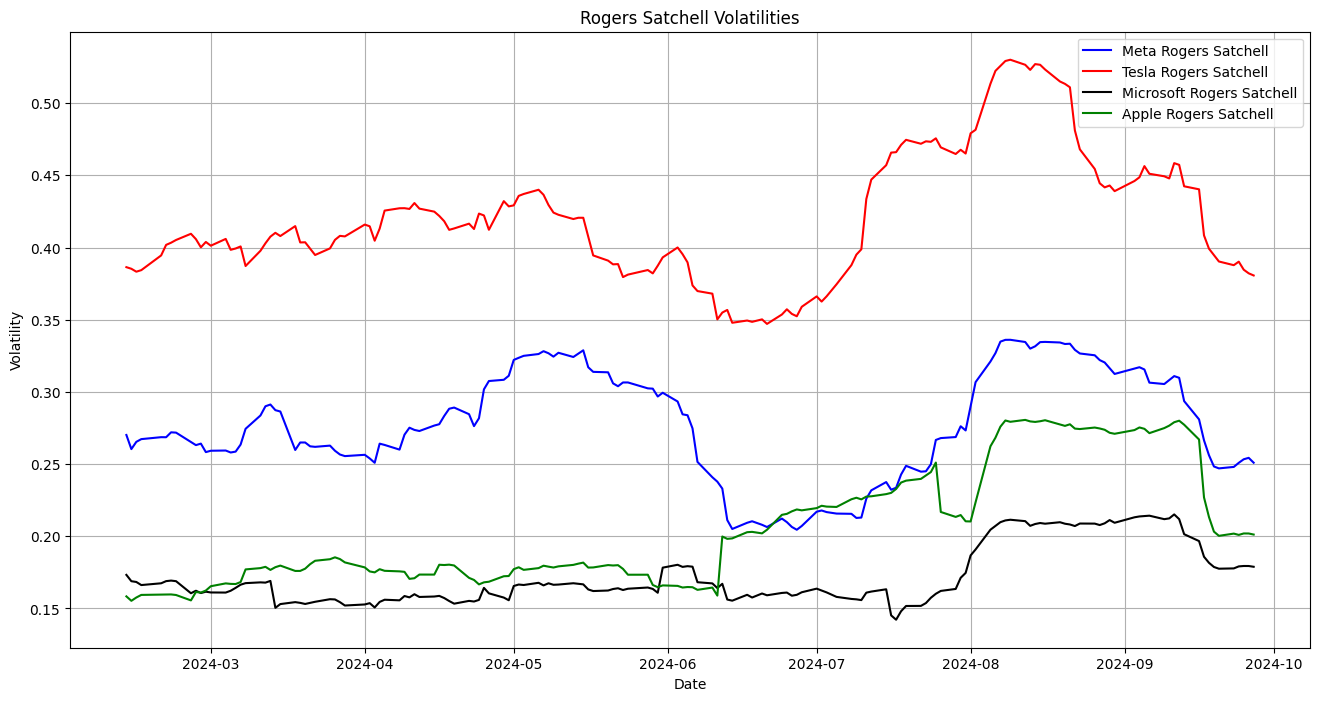

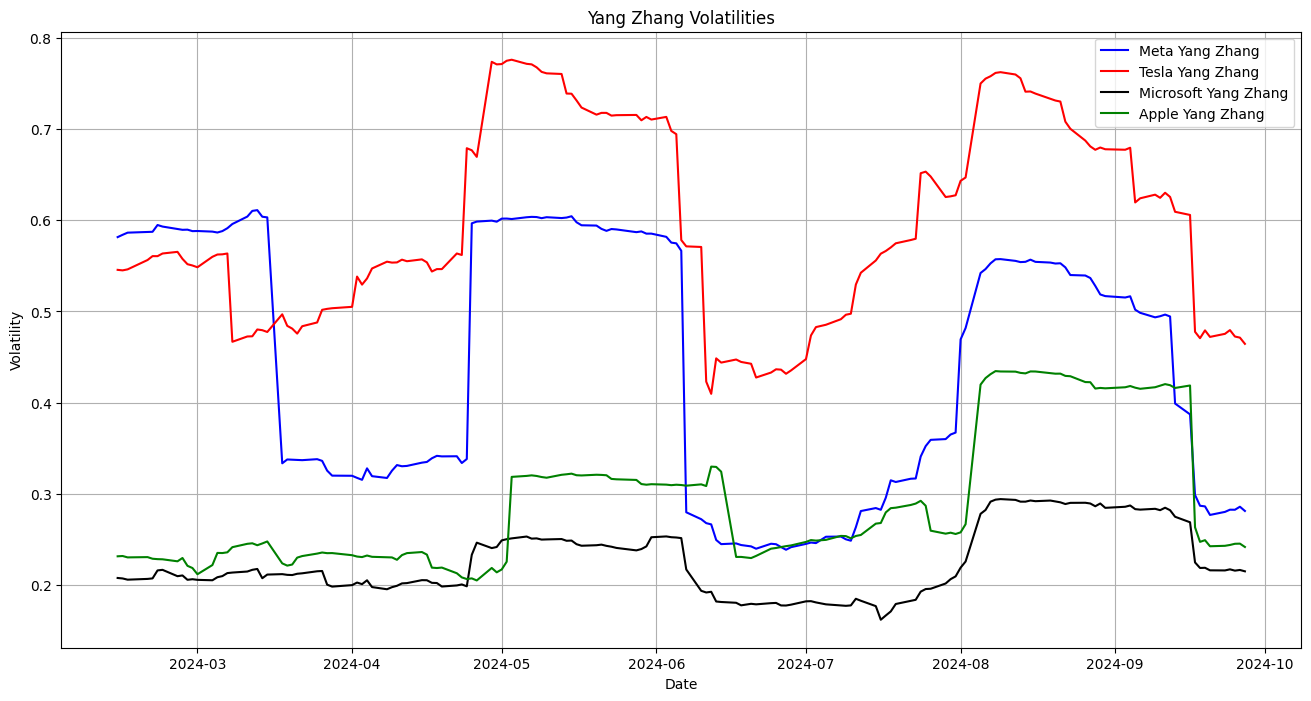

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Set the date range for data retrieval
start_date = "2024-01-01"
end_date = "2024-09-30"

# Downloading relevant stocks (Meta, Tesla, Microsoft, and Aple)
data_meta = yf.download('META', start=start_date, end=end_date)
data_tsla = yf.download('TSLA', start=start_date, end=end_date)
data_msft = yf.download('MSFT', start=start_date, end=end_date)
data_aapl = yf.download('AAPL', start=start_date, end=end_date)

# Adjusted data for RSI calculations
adj_data_meta = data_meta['Adj Close']
adj_data_tsla = data_tsla['Adj Close']
adj_data_msft = data_msft['Adj Close']
adj_data_aapl = data_aapl['Adj Close']

# Function to calculate Average True Range
def average_true_range(price_data, period=14):

    price_data['High-Low'] = price_data['High'] - price_data['Low']
    price_data['High-PrevClose'] = np.abs(price_data['High'] - price_data['Adj Close'].shift(1))
    price_data['Low-PrevClose'] = np.abs(price_data['Low'] - price_data['Adj Close'].shift(1))

    price_data['True Range'] = price_data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    price_data['ATR'] = price_data['True Range'].rolling(window=period).mean()

    return price_data['ATR']

# Function to calculate the Bollinger Bands
def bollinger_bands(price_data, window=14, num_std_dev=2):
    bb_middle = price_data.rolling(window=window).mean()
    bb_middle_std = price_data.rolling(window=window).std()

    bb_high = bb_middle + (bb_middle_std * num_std_dev)
    bb_low = bb_middle - (bb_middle_std * num_std_dev)

    return bb_middle, bb_high, bb_low

# Function to calculate the Keltner Channel
def keltner_channel(price_data, period=14, multiplier=2):

    price_data['TR'] = np.maximum(price_data['High'] - price_data['Low'],
                          np.abs(price_data['High'] - price_data['Close'].shift(1)),
                          np.abs(price_data['Low'] - price_data['Close'].shift(1)))

    price_data['ATR'] = price_data['TR'].rolling(period).mean()

    kc_middle = price_data['Close'].rolling(period).mean()
    kc_high = kc_middle + multiplier * price_data['ATR']
    kc_low = kc_middle - multiplier * price_data['ATR']

    return kc_middle, kc_high, kc_low

# Function to calculate Relative Strength Index
def relative_strength_index(price_data, window=14):
    delta = price_data.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain = pd.Series(gain, index=price_data.index).rolling(window=window).mean()
    loss = pd.Series(loss, index=price_data.index).rolling(window=window).mean()

    rs = gain / loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Function to calculate the Standard Deviation
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    if clean:
        return result.dropna()
    else:
        return result

# Function to calculate the Parkinson Volatility
def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result


# Function to calculate the Garman Klass Volatility
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

# Function to calculate the Hodges Tompkins Volatility
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return

# Function to calculate the Rogers Satchell Volatility
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

# Function to calculate the Yangzhang Volatility
def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

# Calculate all the indicators on all Stocks

meta_atr = average_true_range(data_meta)
tsla_atr = average_true_range(data_tsla)
msft_atr = average_true_range(data_msft)
aapl_atr = average_true_range(data_aapl)

meta_bb_middle= bollinger_bands(adj_data_meta)[0]
meta_bb_high = bollinger_bands(adj_data_meta)[1]
meta_bb_low = bollinger_bands(adj_data_meta)[2]

meta_kc_middle = keltner_channel(data_meta)[0]
meta_kc_high = keltner_channel(data_meta)[1]
meta_kc_low = keltner_channel(data_meta)[2]

meta_rsi = relative_strength_index(adj_data_meta)
tsla_rsi = relative_strength_index(adj_data_tsla)
msft_rsi = relative_strength_index(adj_data_msft)
aapl_rsi = relative_strength_index(adj_data_aapl)

meta_std = standard_deviation(data_meta)
tsla_std = standard_deviation(data_tsla)
msft_std = standard_deviation(data_msft)
aapl_std = standard_deviation(data_aapl)

meta_pv = parkinson(data_meta)
tsla_pv = parkinson(data_tsla)
msft_pv = parkinson(data_msft)
aapl_pv = parkinson(data_aapl)

meta_gkv = garman_klass(data_meta)
tsla_gkv = garman_klass(data_tsla)
msft_gkv = garman_klass(data_msft)
aapl_gkv = garman_klass(data_aapl)

meta_htv = hodges_tompkins(data_meta)
tsla_htv = hodges_tompkins(data_tsla)
msft_htv = hodges_tompkins(data_msft)
aapl_htv = hodges_tompkins(data_aapl)

meta_rsv = rogers_satchell(data_meta)
tsla_rsv = rogers_satchell(data_tsla)
msft_rsv = rogers_satchell(data_msft)
aapl_rsv = rogers_satchell(data_aapl)

meta_yzv = yang_zhang(data_meta)
tsla_yzv = yang_zhang(data_tsla)
msft_yzv = yang_zhang(data_msft)
aapl_yzv = yang_zhang(data_aapl)

# Plot the stock prices at close
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(data_meta['Adj Close'], label='Price of Meta', linestyle='-', color='blue')
plt.plot(data_tsla['Adj Close'], label='Price of Tesla', linestyle='-', color='red')
plt.plot(data_msft['Adj Close'], label='Price of Microsoft', linestyle='-', color='black')
plt.plot(data_aapl['Adj Close'], label='Price of Apple', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prices')
plt.legend()
plt.grid()
plt.show()

# Plot the Average True Range
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(meta_atr, label='Meta ATR', linestyle='-', color='blue')
plt.plot(tsla_atr, label='Tesla ATR', linestyle='-', color='red')
plt.plot(msft_atr, label='Microsoft ATR', linestyle='-', color='black')
plt.plot(aapl_atr, label='Apple ATR', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Average True Range')
plt.legend()
plt.grid()
plt.show()

# Plot the Bollinger Bands
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(data_meta['Adj Close'], label='Price of Meta', linestyle='-', color='Blue')
plt.plot(meta_bb_middle, label='Meta BB Middle', linestyle='--', color='black')
plt.plot(meta_bb_high, label='Meta BB High', linestyle='--', color='red')
plt.plot(meta_bb_low, label='Meta BB Low', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bollinger Bands')
plt.legend()
plt.grid()
plt.show()

# Plot the Keltner Channel on META
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(data_meta['Adj Close'], label='Price of Meta', linestyle='-', color='Blue')
plt.plot(meta_kc_middle, label='Middle', linestyle='--', color='black')
plt.plot(meta_kc_high, label='High', linestyle='--', color='red')
plt.plot(meta_kc_low, label='Low', linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Keltner Channel')
plt.legend()
plt.grid()
plt.show()

# Plot the Relative Strength Index
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(meta_rsi, label='Meta RSI', linestyle='-', color='blue')
plt.plot(tsla_rsi, label='Tesla RSI', linestyle='-', color='red')
plt.plot(msft_rsi, label='Microsoft RSI', linestyle='-', color='black')
plt.plot(aapl_rsi, label='Apple RSI', linestyle='-', color='green')
plt.axhline(70, linestyle='--', color='red')
plt.axhline(30, linestyle='--', color='green')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.title('Relative Strength Index')
plt.ylim(0, 100)
plt.legend()
plt.grid()
plt.show()

# Plot the Standard Deviation
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(meta_std, label='Meta STD', linestyle='-', color='blue')
plt.plot(tsla_std, label='Tesla STD', linestyle='-', color='red')
plt.plot(msft_std, label='Microsoft STD', linestyle='-', color='black')
plt.plot(aapl_std, label='Apple STD', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Standard Deviation')
plt.legend()
plt.grid()
plt.show()

# Plot the Parkinson Volaitities
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(meta_pv, label='Meta Parkinson', linestyle='-', color='blue')
plt.plot(tsla_pv, label='Tesla Parkinson', linestyle='-', color='red')
plt.plot(msft_pv, label='Microsoft Parkinson', linestyle='-', color='black')
plt.plot(aapl_pv, label='Apple Parkinson', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Parkinson Volatilities')
plt.legend()
plt.grid()
plt.show()

# Plot the Garman Klass Volaitities
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(meta_gkv, label='Meta Garman Klass', linestyle='-', color='blue')
plt.plot(tsla_gkv, label='Tesla Garman Klass', linestyle='-', color='red')
plt.plot(msft_gkv, label='Microsoft Garman Klass', linestyle='-', color='black')
plt.plot(aapl_gkv, label='Apple Garman Klass', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Garman Klass Volatilities')
plt.legend()
plt.grid()
plt.show()

# Plot the Hodges Tompkins Volaitities
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(meta_htv, label='Meta Hodges Tompkins', linestyle='-', color='blue')
plt.plot(tsla_htv, label='Tesla Hodges Tompkins', linestyle='-', color='red')
plt.plot(msft_htv, label='Microsoft Hodges Tompkins', linestyle='-', color='black')
plt.plot(aapl_htv, label='Apple Hodges Tompkins', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Hodges Tompkins Volatilities')
plt.legend()
plt.grid()
plt.show()

# Plot the Rogers Satchell Volaitities
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(meta_rsv, label='Meta Rogers Satchell', linestyle='-', color='blue')
plt.plot(tsla_rsv, label='Tesla Rogers Satchell', linestyle='-', color='red')
plt.plot(msft_rsv, label='Microsoft Rogers Satchell', linestyle='-', color='black')
plt.plot(aapl_rsv, label='Apple Rogers Satchell', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Rogers Satchell Volatilities')
plt.legend()
plt.grid()
plt.show()

# Plot the Yang Zhang Volaitities
plt.figure(figsize=(16, 8), dpi=100)
plt.plot(meta_yzv, label='Meta Yang Zhang', linestyle='-', color='blue')
plt.plot(tsla_yzv, label='Tesla Yang Zhang', linestyle='-', color='red')
plt.plot(msft_yzv, label='Microsoft Yang Zhang', linestyle='-', color='black')
plt.plot(aapl_yzv, label='Apple Yang Zhang', linestyle='-', color='green')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Yang Zhang Volatilities')
plt.legend()
plt.grid()
plt.show()